# Welcome to the tutorial measuring attenuation parameters!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553

Hirose, T., Ueda, H., & Fujita, E. (2022). Scattering and intrinsic absorption parameters of Rayleigh waves at 18 active volcanoes in Japan inferred using seismic interferometry. Bulletin of Volcanology, 84(3), 34. https://doi.org/10.1007/s00445-022-01536-w

### This notebook demonstrates inter-station measurements

Step: <br>
0) Data preparing and filtering <br> 1) Calculation of mean-squared (MS) envelopes --> observed energy densities (Eobs) <br> 
2) Calculation of synthesized energy densities (Esyn) via a grid search <br>
3) Determination of best-fit parameters: intrinsic absorption parameter *b* (for single station)<br>

In [1]:
import os
import sys
import glob
import obspy
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math

from obspy.signal.filter import bandpass
from scripts.Esyn_func import *

### Step 0 ---  Data preparing and filtering 

In [2]:
# detremine the h5 files for processing
path = "./" 
data_path = os.path.join(path, "STACK_CC_BH_2020")
sfiles = sorted(glob.glob(os.path.join(data_path, '*PANH*/*.h5')))
print(sfiles)


['./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PANH.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5']


In [3]:
# detremine the component for processing
comp_arr = ["ZZ", "ZR","ZT","RZ","TZ"]
num_cmp=len(comp_arr)
fnum=len(sfiles)
print("Total files number: ",fnum)

# information of the input data:  lagtime (lag), sampling rate (samp)
lag=100
samp=10
leng=int(lag*samp*2+1)
npts=leng
dt=1/samp
print("Lag-time: ",lag,", sampling rate: ",samp,", total data length in points: ",leng)

Total files number:  8
Lag-time:  100 , sampling rate:  10 , total data length in points:  2001


In [4]:
def plot_waveforms(ncmp,wav,fname,comp_arr):
    fig, ax = plt.subplots(1,ncmp, figsize=(16,3), sharex=False)
    
    for n in range(ncmp):
        absy=max(wav[n][1], key=abs)
        ax[n].set_ylim(absy*-1,absy)
        ax[n].plot(wav[n][0],wav[n][1])
        ax[n].set_xlabel("time [s]")
        ax[n].set_title(fname+" "+comp_arr[n])
    fig.tight_layout()
    plt.show()

In [5]:
stackf=np.ndarray((fnum,num_cmp,2,leng))  
print(stackf.shape)
vdist=np.zeros((fnum,1))  # S-R distance array
fname=[]                  # file name array


aa=0
# loop through each station-pair
for sfile in sfiles:
    ncmp=0
    
    # skip auto-correlation
    if ( sfile.split("/")[3].split("_")[0] == sfile.split("/")[3].split("_")[1].split(".h5")[0] ):  
        continue
    fname.append(sfile.split("/")[3].split(".h5")[0])
    for ccomp in comp_arr:        
        print(aa, sfile, ccomp)
        # read stacked waveforms
        if ( read_pyasdf(sfile,ccomp) == None):
            continue
        dist,dt, tvec,sdata  = read_pyasdf(sfile,ccomp) # read waveform from pyasdf 
        stackf[aa][ncmp]=[tvec,sdata]
        vdist[aa]=dist
        ncmp=ncmp+1
    #plot_waveforms(num_cmp,stackf[aa],fname[aa],comp_arr)
    
    aa=aa+1
fnum=len(fname)


(8, 5, 2, 2001)
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZZ
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZR
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZT
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 RZ
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 TZ
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZZ
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZR
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZT
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 RZ
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 TZ
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZZ
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZR
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZT
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 RZ
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 TZ
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZZ
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZR
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZT
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 RZ
3 ./STACK_CC_BH

In [6]:
def plot_filtered_waveforms(freq,tt,wav,fname):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,3), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=max(wav[fb], key=abs)
        #absx=max(tt, key=abs)
        #ax[fb].set_xlim(absx*-1,absx)
        ax[fb].set_ylim(absy*-1,absy)
        ax[fb].plot(tt,wav[fb], "k-", linewidth=0.2)
        #ax[fb].plot(wav_fold[0],wav_fold[fb+1], "b-", linewidth=1)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude")
        ax[fb].set_title( "%s   %s   @%4.2f-%4.2f Hz" % ( fname,ccomp,fmin,fmax ) )
    
    fig.tight_layout()
    plt.show()

### Step 1 --- Calculation of mean-squared (MS) envelopes --> observed energy densities (***Eobs***)
--> normalized MS envelope is referred to as the observed energy density Eobs 

In [7]:
freq = [0.5, 0.8, 1, 4]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1

indx = npts // 2                      # half-side number of points
MSE=np.ndarray((fnum,num_cmp,nfreq+1,npts)) # filtered two-side averaged stack CF

for aa in range (fnum):
    dafbp=np.ndarray((nfreq,npts))
      
    for ncmp in range (len(comp_arr)):
        ccomp=comp_arr[ncmp]
        print(fname[aa],ccomp)
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]
            tt = np.arange(0, npts) * dt
            data = stackf[aa][ncmp][1]
            dafbp[fb] = bandpass(data, fmin, fmax, int(1 / dt), corners=4, zerophase=True)
        
        MSE[aa][ncmp]=[stackf[aa][ncmp][0],dafbp[0],dafbp[1],dafbp[2]] 
        #plot_filtered_waveforms(freq,stackf[aa][ncmp][0],dafbp,fname[aa])



CC.PANH_CC.PR01 ZZ
CC.PANH_CC.PR01 ZR
CC.PANH_CC.PR01 ZT
CC.PANH_CC.PR01 RZ
CC.PANH_CC.PR01 TZ
CC.PANH_CC.PR02 ZZ
CC.PANH_CC.PR02 ZR
CC.PANH_CC.PR02 ZT
CC.PANH_CC.PR02 RZ
CC.PANH_CC.PR02 TZ
CC.PANH_CC.PR03 ZZ
CC.PANH_CC.PR03 ZR
CC.PANH_CC.PR03 ZT
CC.PANH_CC.PR03 RZ
CC.PANH_CC.PR03 TZ
CC.PANH_CC.PR04 ZZ
CC.PANH_CC.PR04 ZR
CC.PANH_CC.PR04 ZT
CC.PANH_CC.PR04 RZ
CC.PANH_CC.PR04 TZ
CC.PANH_CC.PR05 ZZ
CC.PANH_CC.PR05 ZR
CC.PANH_CC.PR05 ZT
CC.PANH_CC.PR05 RZ
CC.PANH_CC.PR05 TZ
CC.PANH_CC.RUSH ZZ
CC.PANH_CC.RUSH ZR
CC.PANH_CC.RUSH ZT
CC.PANH_CC.RUSH RZ
CC.PANH_CC.RUSH TZ
CC.PANH_CC.SIFT ZZ
CC.PANH_CC.SIFT ZR
CC.PANH_CC.SIFT ZT
CC.PANH_CC.SIFT RZ
CC.PANH_CC.SIFT TZ


In [8]:
def plot_envelope(comp_arr,freq,msv,msv_mean,fname,vdist):
    
    nfreq = len(freq) - 1
    ncmp = len(comp_arr)
    
    fig, ax = plt.subplots(ncmp+1,nfreq, figsize=(16,10), sharex=False)   
    for n in  range(len(comp_arr)):
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]    
            ax[n,fb].plot(msv[n][0][:], msv[n][fb+1], "k-", linewidth=0.5)
            ax[n,fb].set_title("%s   %.2fkm  %s   @%4.2f-%4.2f Hz" % (fname,vdist,comp_arr[n],fmin,fmax))
            ax[n,fb].set_xlabel("Time [s]")
            ax[n,fb].set_ylabel("Amplitude")
            
    for fb in range(nfreq):
        ax[-1,fb].plot(msv_mean[0], msv_mean[fb+1], "b-", linewidth=1)
        ax[-1,fb].set_title(" Mean Squared Value %.2fkm  @%4.2f-%4.2f Hz" % (vdist,fmin,fmax))
        ax[-1,fb].set_xlabel("Time [s]")
        ax[-1,fb].set_ylabel("Amplitude")            

    plt.tight_layout()   
    plt.show()            
            

In [9]:
# get the mean-squared value on each componet and also the average waveform
msv=np.ndarray((fnum,num_cmp,nfreq+1,npts))
msv_mean=np.ndarray((fnum,nfreq+1,npts))
msv[:][:][:][:]=0.
msv_mean[:][:][:]=0.
#print(msv.shape)

winlen=[8,4,2]   # smoothing window lengths corresponding to the frequency bands
for aa in range(fnum):

    for ncmp in  range(len(comp_arr)):
        ccomp=comp_arr[ncmp]
        msv[aa][ncmp][0]=MSE[aa][ncmp][0][:]
        for fb in range(nfreq):
            data=MSE[aa][ncmp][fb+1][:]
            fmin=freq[fb]
            fmax=freq[fb+1]
        
            para = { 'winlen':winlen[fb], 'dt':dt , 'npts': len(data)}
            msv[aa][ncmp][fb+1]=get_smooth(data, para)
            
            msv[aa][ncmp][fb+1]=msv[aa][ncmp][fb+1]/np.max(msv[aa][ncmp][fb+1])  # self-normalized 
    
    msv_mean[aa][0]=msv[aa][0][0][:]
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        for ncmp in range(len(comp_arr)):
            msv_mean[aa][fb+1]+=msv[aa][ncmp][fb+1][:]
        msv_mean[aa][fb+1]=msv_mean[aa][fb+1]/len(comp_arr)
        
    #plot_envelope(comp_arr,freq,msv[aa],msv_mean[aa],fname[aa],vdist[aa])


In [10]:
def plot_fmsv_waveforms(freq,wav,fname,noise_level,twin):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,2), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=1 #max(wav[fb], key=abs)
        ax[fb].plot([wav[0][0],wav[0][-1]],[noise_level[fb],noise_level[fb]],c='blue',marker='.',ls='--', linewidth=2)
        
        ax[fb].plot([twin[fb][0],twin[fb][0]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
        ax[fb].plot([twin[fb][1],twin[fb][1]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
        ax[fb].set_yscale('log', base=10)
        ax[fb].plot(wav[0],wav[fb+1], "k-", linewidth=0.5)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude in log-scale")
        ax[fb].set_title( "%s   @%4.2f-%4.2f Hz" % ( fname,fmin,fmax ) )
    fig.tight_layout()
    plt.show()

0 0 363 , window:  [12.78301371 36.3       ]
0 1 381 , window:  [14.55037984 38.1       ]
0 2 324 , window:  [17.51990869 32.4       ]
CC.PANH_CC.PR01


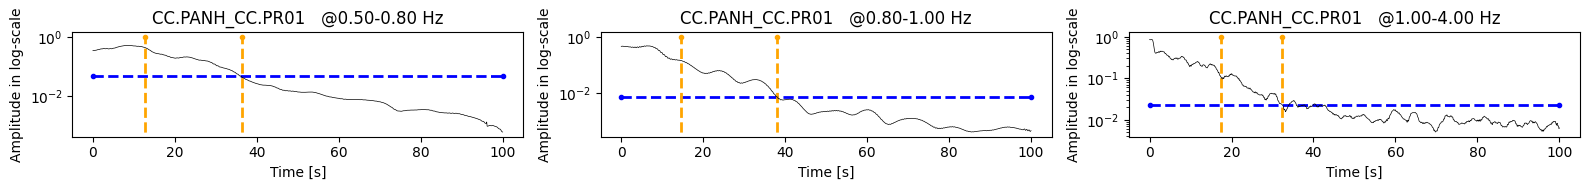

1 0 331 , window:  [13.16927015 33.1       ]
1 1 408 , window:  [15.00686472 40.8       ]
1 2 317 , window:  [18.07783466 31.7       ]
CC.PANH_CC.PR02


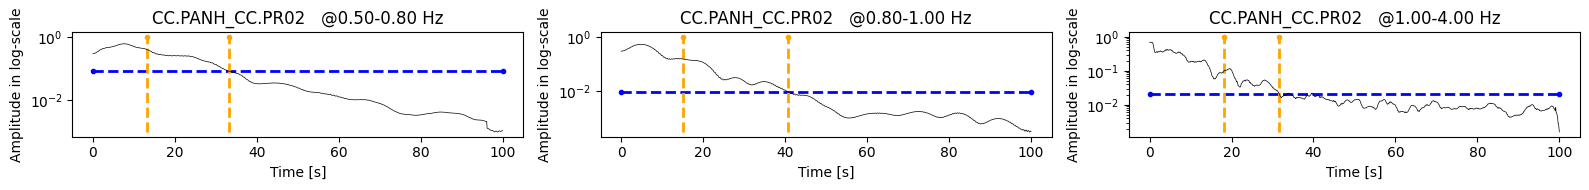

2 0 364 , window:  [12.59304545 36.4       ]
2 1 345 , window:  [14.3258719 34.5      ]
2 2 361 , window:  [17.2455101 36.1      ]
CC.PANH_CC.PR03


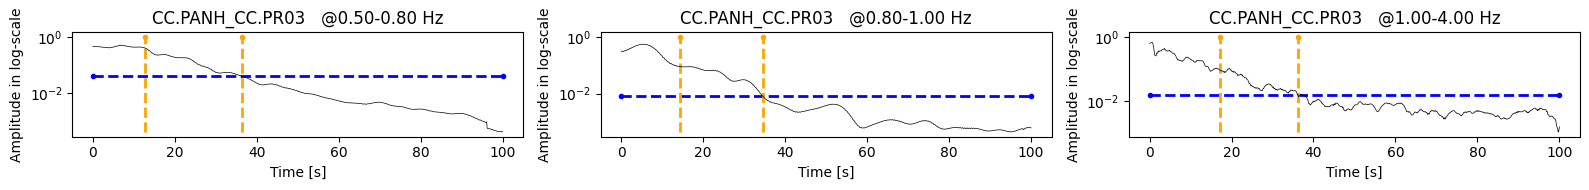

3 0 313 , window:  [11.58050889 31.3       ]
3 1 350 , window:  [13.12923778 35.        ]
3 2 288 , window:  [15.78295729 28.8       ]
CC.PANH_CC.PR04


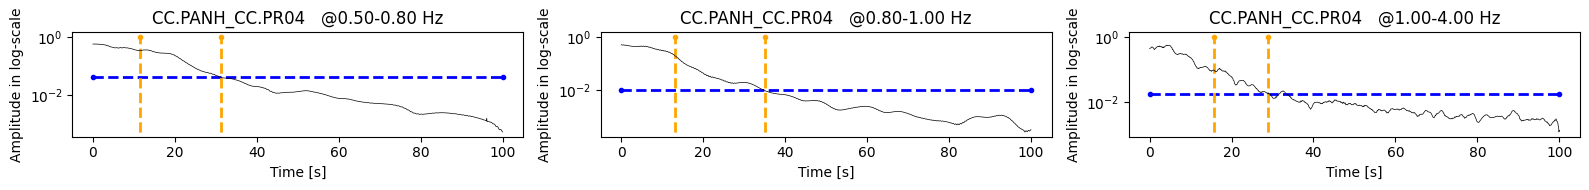

4 0 327 , window:  [10.01453825 32.7       ]
4 1 332 , window:  [11.27854521 33.2       ]
4 2 325 , window:  [13.5209997 32.5      ]
CC.PANH_CC.PR05


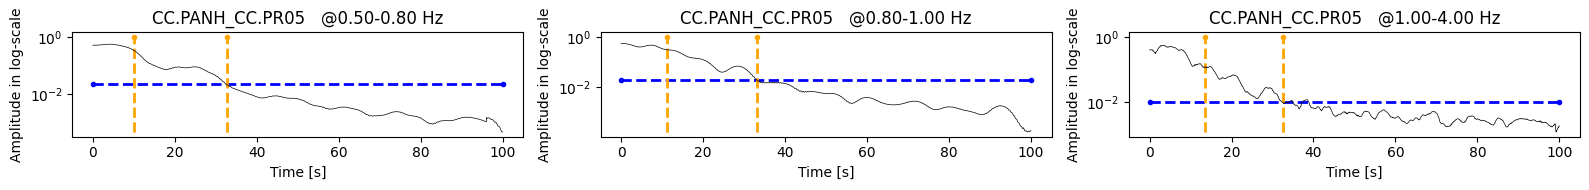

5 0 380 , window:  [10.04590533 38.        ]
5 1 421 , window:  [11.31561539 42.1       ]
5 2 340 , window:  [13.5663077 34.       ]
CC.PANH_CC.RUSH


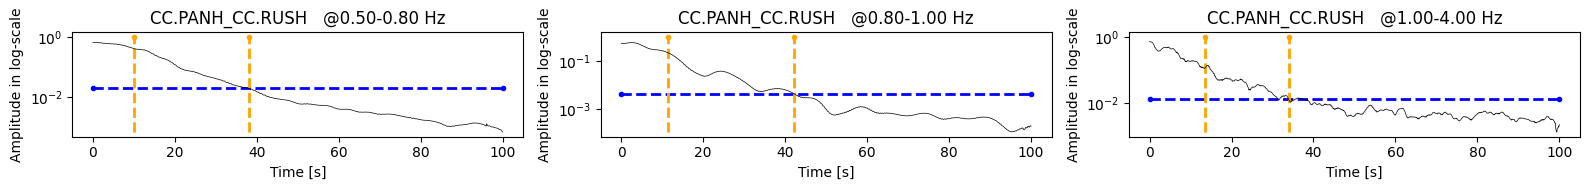

6 0 320 , window:  [10.11536437 32.        ]
6 1 340 , window:  [11.39770334 34.        ]
6 2 333 , window:  [13.66663742 33.3       ]
CC.PANH_CC.SIFT


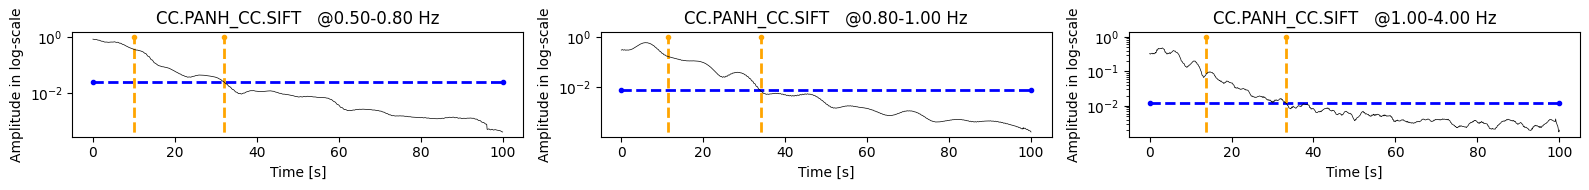

In [11]:
# get symmetric waveforms and determine the measuring window based on noise level (here is using n times of mad)
indx = npts // 2                      # half-side number of points
data_sym=np.ndarray((nfreq,indx+1)) # two-side averaged stack CF
fmsv_mean=np.ndarray((fnum,nfreq+1,indx+1))

# noise level setting
ratio=4
level=np.ndarray((fnum,nfreq,1))
twinbe=np.ndarray((fnum,nfreq,2))

cvel=[2.6, 2.2, 1.8]    # Rayleigh wave velocities over the freqency bands

for aa in range (fnum):
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]            # stack positive and negative lags  
        sym=get_symmetric(msv_mean[aa][fb+1],indx)
        data_sym[fb]=sym
        
        Val_mad=mad(sym)
        level[aa][fb]=Val_mad*ratio
    
        twinbe[aa][fb][0]= (vdist[aa]/cvel[fb]) + (1/fmin)*0.5
        
        for pt in range( int(twinbe[aa][fb][0]/dt),len(sym),1):
            if (sym[pt] < float(level[aa][fb])):
                twinbe[aa][fb][1]=float(pt/samp)
                print(aa,fb,pt,", window: ",twinbe[aa][fb])
                break
    
    
    print(fname[aa])  
    fmsv_mean[aa]=[msv[aa][0][0][indx:],data_sym[0],data_sym[1],data_sym[2]]
    plot_fmsv_waveforms(freq,fmsv_mean[aa],fname[aa],level[aa],twinbe[aa])
    

### Step 2 --- Calculation of synthesized energy densities (***Esyn***) via a grid search 
### #The 2-D radiative transfer equation for scalar waves  ***(Shang and Gao 1988; Sato 1993)***
Assuming isotropic scattering and source radiation in infinite medium to calculate ***synthesized energy densities  Esyn*** :

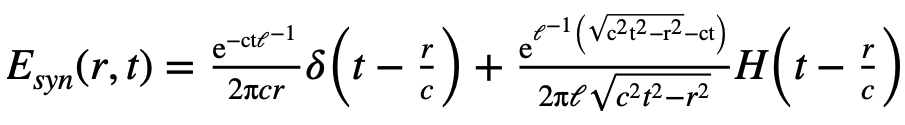

* l scattering mean free paths 
* c is the Rayleigh wave velocity
* r is the distance between the source and receiver
* H is the Heaviside function

* ### ***b is intrinsic absorption parameter***

The sum of squared residuals (SSR) between *Eobs and Esyn* was calculated, and the values of the parameters l and b that minimize SSR through the grid search were determined. <br>


An energy density with the spatially homogeneous intrinsic absorption is obtained by multiplying e^-bt with the right-hand-side of Equation (1), where ***b is intrinsic absorption parameter***


* Hirose et al. (2022) --> 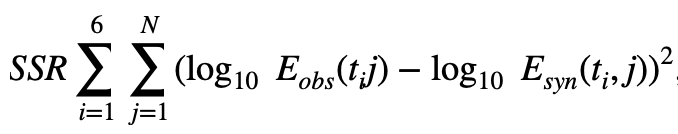

In [12]:
def plot_fitting_curves(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist):
    numb=len(intrinsic_b)
    plt.figure(figsize=(8,2))
    for nb in range(numb):
    
        plt.yscale('log', base=10)
        #plt.xlim(0,120) 
        plt.ylim( np.min(Eobs[nb][:-2]/2) , np.max(Eobs[nb][:-2]*2) )
        plt.plot( tt, Eobs[nb], "k-", linewidth=0.5)
        plt.plot( tt, Esyn[nb], "b-", linewidth=1)  

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f~%.2f"
            % ( fname,dist,fmin,fmax,mean_free,y[0],y[-1]))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()            
                    

In [31]:
mfpx=np.zeros(160)        # mean_free_path search array
intby=np.zeros(30)      # intrinsic_b search array

In [32]:
# getting the sum of squared residuals (SSR) between Eobs and Esyn  
SSR_final=np.ndarray((len(mfpx),len(intby)))
SSR=np.ndarray((nfreq,len(mfpx),len(intby)))
SSR[:][:][:]=0.

for fb in range(nfreq):
    fmin=freq[fb]
    fmax=freq[fb+1]
    c=cvel[fb]
    SSR_final[:][:]=0.
    
    print(f"Working on frequency band of {fmin}-{fmax} Hz")
    # parameters for getting the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':fb, 'vdist':vdist, 'npts':npts, 'dt':dt, 'cvel':c, \
        'mfp':mfpx, 'intb':intby, 'twin':twinbe, 'fmsv':fmsv_mean }

    # call function get_SSR
    SSR_final, mfpx, intby = get_SSR(fnum, para)
    
    SSR[fb]=SSR_final

Working on frequency band of 0.5-0.8 Hz
Working on frequency band of 0.8-1 Hz
Working on frequency band of 1-4 Hz


## Step 3--- Determination of best-fit parameters and plotting 

In [35]:
def plot_grid_searching(freq,SSR):
    nfreq=len(freq)-1
    
    fig, ax = plt.subplots(1,nfreq, figsize=(16,4), sharex=False)
    
    for fb in range(nfreq): 
        fmin=freq[fb]
        fmax=freq[fb+1]

        loc=np.where(SSR[fb].T == np.amin(SSR[fb].T))
        locx=list(zip(loc[0], loc[1]))
        print("%4.2f-%4.2f Hz " % (fmin,fmax),"loc ",loc)
        ymin=intby[loc[0]]
        xmin=mfpx[loc[1]]
        print(" intrinsic_b %.2f " % ymin,"mean_free: %.2f " % xmin)

        grid = SSR[fb].T
        im=ax[fb].imshow(grid,extent=(mfpx.min(), mfpx.max(), intby.max(), intby.min()), aspect='auto',cmap = 'viridis_r',interpolation='spline16' )
        #im=ax[fb].imshow(grid,aspect='auto',cmap = 'viridis_r' )
        im.set_clim(1,10)    
        cb=plt.colorbar(im,extend='max')
        cb.set_label('SSR/SSR_min', rotation=90, labelpad=14)
        ax[fb].set_title("All pairs SSR  @%4.2f-%4.2f Hz" % (fmin,fmax) )
        ax[fb].set_xlabel("mean free path")
        ax[fb].set_ylabel("intrinsic_b")
        ax[fb].invert_yaxis()
        ax[fb].plot(xmin,ymin,"+", markersize=20, color='red')

    plt.tight_layout() 
    plt.show()     
    


['CC.PANH_CC.PR01', 'CC.PANH_CC.PR02', 'CC.PANH_CC.PR03', 'CC.PANH_CC.PR04', 'CC.PANH_CC.PR05', 'CC.PANH_CC.RUSH', 'CC.PANH_CC.SIFT']
0.50-0.80 Hz  loc  (array([6]), array([82]))
 intrinsic_b 0.07  mean_free: 16.80 
0.80-1.00 Hz  loc  (array([8]), array([159]))
 intrinsic_b 0.09  mean_free: 32.20 
1.00-4.00 Hz  loc  (array([11]), array([159]))
 intrinsic_b 0.12  mean_free: 32.20 


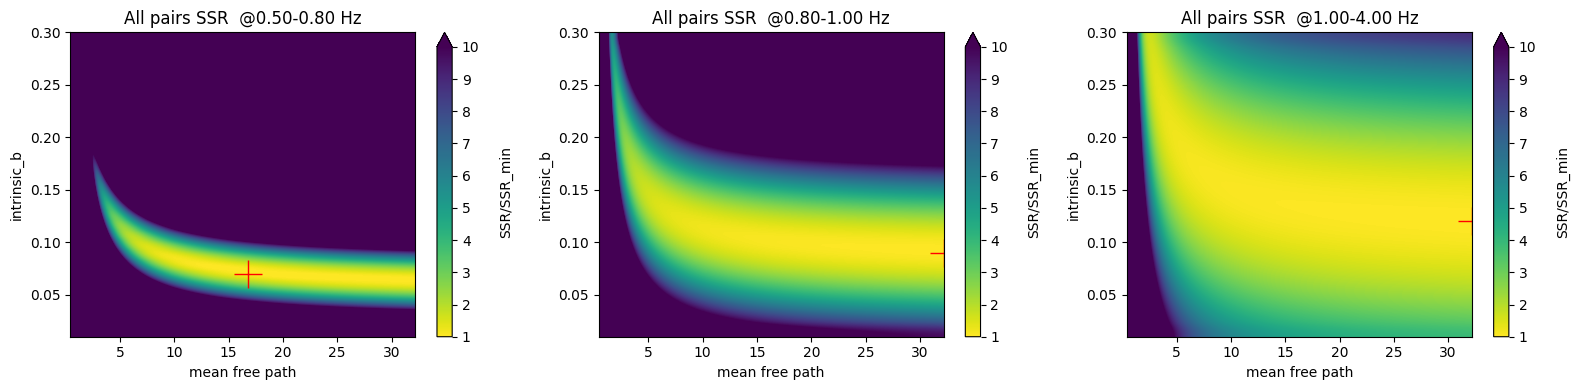

In [36]:
print(fname)
plot_grid_searching(freq,SSR)
